In [245]:
import librosa
import numpy as np
import IPython.display as ipd
import scipy.io.wavfile as wavfile

from tensorflow import keras
import tensorflow as tf


In [246]:
def read_as_spectrogram(filename: str, sample_size=2048, sample_rate=44100) -> np.ndarray:
    ''' Convert audio file to a spectrogram, contained in a numpy ndarray
    :param filename: location of audio file
    :return: the audio file as a spectrogram with the shape (1 + sample_size/2, x.shape[0] / hop_length)
    '''
    # Currently defaulting sample_rate to 44100, based off intel. Librosa default is 22050.

    hop_length = sample_size // 2

    audio, sr = librosa.load(filename, sample_rate)
    spectrogram = librosa.stft(audio, n_fft=sample_size, hop_length=hop_length)
    mag_spectrogram = np.abs(spectrogram)
    return mag_spectrogram, sr


def spectrogram_to_wav(spectrogram: np.ndarray, output_file: str, sample_size=2048, sample_rate=44100) -> None:
    ''' Convert a spectrogram into audio, and write it to an audio file
    :param spectrogram: Numpy array that represents spectrogram
    :param output_file: Path for file to write to
    :return:
    '''
    # Currently defaulting sample_rate to 44100, based off intel. Librosa default is 22050.

    hop_length = sample_size // 2
    audio = librosa.griffinlim(spectrogram, hop_length=hop_length)
    print("finished griffin lim")
    wavfile.write(output_file, sample_rate, audio)


In [247]:
def gram_matrix(tensor):
    #https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow
    """
    Computes the gram matrix of the input tensor, assuming it has exactly one layer.
    :param input_tensor: input tensor
    :return: gram matrix of the input tensor
    """
    temp = tensor
    temp = tf.squeeze(temp)
    reshaped = tf.reshape(temp, [temp.shape[2], temp.shape[0] * temp.shape[1]])

    return tf.matmul(reshaped, tf.transpose(reshaped))

In [248]:
def get_content_loss(targets, outputs):
        return tf.reduce_mean(tf.losses.mean_squared_error(targets, outputs))
        
def get_style_loss(targets, outputs):
        return tf.reduce_mean(tf.losses.mean_squared_error(gram_matrix(targets), gram_matrix(outputs)))

In [249]:
# I dont know if dense layers will be required have to look at the paper to see the model
def model_audio_transfer( combination_spectrogram):
    # note according to keras lib sequential model is not beneficial here and vgg19 
    #is for images and cannot be used for audio 
    # for better result add dense layers have 3 functions and name them blocks and then these block 
    # would have softmax and dense layers
    # Flatten would be needed
    _, co_time, co_frequency, co_channel = tuple(combination_spectrogram.shape)
    print(combination_spectrogram.shape)
    
    model = tf.keras.layers.Conv2D(64, 3, activation="relu",
                               strides = (1, 1), input_shape=(1, co_time, co_frequency, co_channel))
    # Decreased filter size b/c of mem issues.
    return model

In [250]:
def compute_loss(style_weight, content_weight, content_features, style_features, combination_features):

  

    
    # Add content loss
    # dividing by 2 b/c following formula from Zhixian paper
    loss = (content_weight/2) * get_content_loss(content_features, combination_features)
    # Add style loss

    # Zhixian paper: N is # of feature maps, M is height * width (time * freq)
    M = combination_features.shape[1] * combination_features.shape[2]
    N = combination_features.shape[-1]
    style_factor = (style_weight/ (4 * N** 2 * M ** 2))
    style_loss = get_style_loss(style_features, combination_features)
    loss += style_weight * style_loss

    # Add total variation loss
    #loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [251]:
def train_step(model,optimizer, content_features, style_features, combination_spectrogram, style_weight, content_weight):
    with tf.GradientTape() as tape:

        combination_features = model(combination_spectrogram)
        loss = compute_loss(style_weight, content_weight, content_features, style_features, combination_features)
        grads = tape.gradient(loss, combination_spectrogram)
    
    optimizer.apply_gradients([(grads, combination_spectrogram)])
    # TODO: The loss is not decreasing. Make sure the grads are actual numbers. If so,then the optimizer params are off?
    return loss, grads

In [252]:

content_spectrogram, content_rate = read_as_spectrogram("content.wav")
print("original content_spectrogram shape")
print(content_spectrogram.shape)
style_spectrogram, style_rate = read_as_spectrogram("style.wav")



original content_spectrogram shape
(1025, 1296)


optimizer config, {'name': 'SGD', 'learning_rate': 0.6, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
style weight: 0.001 content weight: 0.5
(1, 1025, 1296, 1)
style features shape: (1, 1023, 1291, 64)
num of iterations:100
initial loss: 10601362358272.0
final loss: 36560876.0


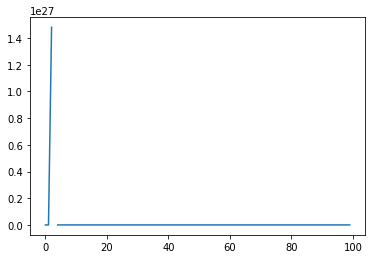

In [253]:
optimizer = keras.optimizers.SGD(
    learning_rate=0.6
)
print(f'optimizer config, {optimizer.get_config()}')
style_weight = 0.001
content_weight = 0.5
print(f'style weight: {style_weight} content weight: {content_weight}')


s_time, s_frequency = style_spectrogram.shape
c_time, c_frequency = content_spectrogram.shape


# change 1 to the number of trainable batches ie the first dimension
content_spectrogram = tf.reshape(content_spectrogram, [1, c_time , c_frequency, 1])
style_spectrogram = tf.reshape(style_spectrogram, [1, s_time, s_frequency, 1])
combination_spectrogram = tf.Variable(tf.identity(content_spectrogram))

model = model_audio_transfer(combination_spectrogram)


content_features = model(content_spectrogram)

style_features = model(style_spectrogram)
print(f'style features shape: {style_features.shape}')


iterations = 100
print(f'num of iterations:{iterations}')
loss_history = []
for i in range(iterations):
    loss, grads = train_step(
        model, optimizer, content_features, style_features, combination_spectrogram, style_weight, content_weight
    )
    loss_history.append(loss)
    if i == 1:
      print(f"initial loss: {loss}")

print(f"final loss: {loss}")
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [254]:
final_combination_spectrogram = tf.squeeze(combination_spectrogram)
print('pre conversion spectrogram dims')
print(final_combination_spectrogram.shape)
# I'm assuming we just need to get the spectrogram back to it's original shape
# its (1, x,y,1), and was originally (x,y) so just sqeeze
merge_audio = spectrogram_to_wav(final_combination_spectrogram.numpy(), "output.wav")
print("wrote file")



pre conversion spectrogram dims
(1025, 1296)


ParameterError: ignored